# Inference

In [3]:
import diffusers
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image 

model_path = '/home/sonia/cycloneSVD/windmag_io/'
ckpt_name = 'checkpoint-50000'
real_data_path = '/home/cyclone/train/windmag_io'

In [2]:
# feature_extractor = CLIPImageProcessor.from_pretrained('/mnt/data/sonia/svd/outputs/feature_extractor')
# image_encoder = CLIPVisionModelWithProjection.from_pretrained('/mnt/data/sonia/svd/outputs/image_encoder')
# scheduler = diffusers.DDPMScheduler.from_pretrained("/mnt/data/sonia/svd/outputs/scheduler")
# unet = diffusers.UNetSpatioTemporalConditionModel.from_pretrained('/mnt/data/sonia/svd/outputs/unet')
# vae = diffusers.AutoencoderKLTemporalDecoder.from_pretrained('/mnt/data/sonia/svd/outputs/vae')
feature_extractor = CLIPImageProcessor.from_pretrained(os.path.join(model_path, 'feature_extractor'))
image_encoder = CLIPVisionModelWithProjection.from_pretrained(os.path.join(model_path, 'image_encoder'))
scheduler = diffusers.DDPMScheduler.from_pretrained(os.path.join(model_path, 'scheduler'))
unet = diffusers.UNetSpatioTemporalConditionModel.from_pretrained(os.path.join(model_path, ckpt_name, 'unet'))
vae = diffusers.AutoencoderKLTemporalDecoder.from_pretrained(os.path.join(model_path, 'vae'))
pipeline = diffusers.StableVideoDiffusionPipeline.from_pretrained(
    'stabilityai/stable-video-diffusion-img2vid',
    image_encoder=image_encoder,
    vae=vae,
    unet=unet,
    # revision=args.revision,
)
width = height = 32
num_frames = 8
n = 500 # desired eval set size

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# just to test..
frame_path = os.path.join(real_data_path, 'demo.npy')
img = diffusers.utils.load_image(Image.fromarray(np.load(frame_path)))
pipeline = pipeline.to('cuda')
video_frames = pipeline(
    img,
    height=height,
    width=width,
    num_frames=num_frames,
    decode_chunk_size=8,
    motion_bucket_id=127,
    fps=7,
    noise_aug_strength=0.02,
    # generator=generator,
).frames[0]
pipeline = pipeline.to('cpu')
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter(f'sample.mp4', fourcc, 1.5, (width, height))
for i in range(num_frames):
    frame_arr = np.array(video_frames[i]).astype(np.uint8)
    frame_arr = (255 * frame_arr / frame_arr.max()).astype(np.uint8)
    video.write(frame_arr)
video.release()

  0%|          | 0/25 [00:00<?, ?it/s]

In [49]:
np.array(video_frames[i]).min()

np.uint8(0)

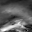

In [52]:
from IPython.display import display
frame_path = os.path.join(real_data_path, 'demo.npy')
img = Image.fromarray(255*np.load(frame_path)/arr.max())
img.convert("L")

In [22]:
arr=np.load(frame_path)
arr.min(), arr.max(), arr.mean(), arr.std()

(np.float32(0.3563924),
 np.float32(13.498513),
 np.float32(5.037656),
 np.float32(2.4258137))

In [60]:
datadir = '/home/cyclone/train/windmag_io'
outputdir = os.path.join(real_data_path, 'synth') #FKA evals
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
allexamples = os.listdir(real_data_path)
n=50
examples = random.sample(allexamples, n)
with open(os.path.join(outputdir, 'examples.txt'), 'w+') as f:
    f.write('\n'.join(examples))
preds = []

pipeline = pipeline.to('cuda')
for example in tqdm(examples):
    imgs = [] 
    for i in range(num_frames):
        frame_path = os.path.join(real_data_path, example, f'{i}.npy')
        img = diffusers.utils.load_image(Image.fromarray(np.load(frame_path)))
        imgs.append(img)
        
    sample = pipeline(
        imgs[0],
        height=height,
        width=width,
        num_frames=num_frames,
        decode_chunk_size=8,
        motion_bucket_id=127,
        fps=7,
        noise_aug_strength=0.02,
    ).frames[0]
    preds.append(sample)
    os.makedirs(os.path.join(outputdir, example), exist_ok=True)
    for i in range(num_frames):
        frame_arr = np.array(sample[i])
        np.save(os.path.join(outputdir, example, f'{i}.npy'), frame_arr)
pipeline = pipeline.to('cpu')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:47,  1.04it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:01<00:45,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:02<00:44,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:03<00:43,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:04<00:42,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:05<00:41,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:06<00:40,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:07<00:39,  1.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:08<00:38,  1.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:09<00:37,  1.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [00:10<00:36,  1.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [00:12<00:34,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [00:13<00:33,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 30%|███       | 15/50 [00:14<00:32,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [00:15<00:31,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [00:15<00:31,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [00:16<00:30,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [00:17<00:29,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 40%|████      | 20/50 [00:18<00:28,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [00:19<00:27,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [00:20<00:26,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:21<00:25,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 48%|████▊     | 24/50 [00:22<00:24,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 50%|█████     | 25/50 [00:23<00:23,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [00:24<00:22,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [00:25<00:21,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [00:26<00:20,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [00:27<00:19,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 60%|██████    | 30/50 [00:28<00:18,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [00:29<00:17,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [00:30<00:16,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [00:31<00:16,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [00:32<00:15,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 70%|███████   | 35/50 [00:32<00:14,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:33<00:13,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [00:34<00:12,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [00:35<00:11,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [00:36<00:10,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 80%|████████  | 40/50 [00:37<00:09,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [00:38<00:08,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [00:39<00:07,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [00:40<00:06,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [00:41<00:05,  1.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [00:42<00:04,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [00:43<00:03,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [00:44<00:02,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [00:45<00:01,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [00:46<00:00,  1.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


# Eval

In [44]:

import os 
import numpy as np 
realpath = '/home/cyclone/train/windmag_natlantic'

# load all train examples
train=[]
ids = []
for stormdir in sorted(os.listdir(realpath)):
    if not os.path.isdir(os.path.join(realpath, stormdir)) or stormdir=='synth':
        continue
    ids.append(stormdir)
    storm = []
    for i in range(8):
        p = os.path.join(realpath, stormdir, f'{i}.npy')
        img = np.load(p)
        img = np.nan_to_num(img, 0) # replace NAN (missing value) with 0
        storm.append(np.array(img))
    train.append(np.stack(storm))
train = np.stack(train) # concatenate them all together into one matrix
train.shape

(387, 8, 32, 32)

In [45]:
composite=np.mean(train, axis=0) # make a "composite" by averaging over all storms
composite.shape

(8, 32, 32)

In [47]:
composite.mean(), composite.std()

(np.float64(6.233845682705272), np.float64(0.9805870115888183))

In [ ]:
# COMMENTED OUT -- ASSUMES PNG FORMAT BUT NPY FORMAT SYNTHETICS DONT EXIST YET
# load synthetics 
# synth = []
# for stormdir in sorted(os.listdir(synthpath)):
#     if not os.path.isdir(os.path.join(synthpath, stormdir)):
#         continue
#     storm = []
#     for i in range(8):
#         p = os.path.join(synthpath, stormdir, f'{i}.png')
#         img = im.open(p)
#         storm.append(np.array(img))
#     synth.append(np.stack(storm))